In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw




Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw




Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Processing...


C:\Users\Computer Store\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

In [7]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
device = torch.device('cuda:0')
D = D.to(device)
G = G.to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# scale image back to (0, 1)
def scale_image(img):
    out = (img + 1) / 2
    return out

In [11]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [12]:
# Training Loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
    for inputs, _ in data_loader:
        # don't need targets
        
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)
        
        # set ones and zeros to correct size
        ones = ones_[:n]
        zeros = zeros_[:n]
        
        ##############################
        #### Train Discriminator #####
        ##############################
        
        # real images
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)
        
        # fake images
        noise = torch.randn(n, latent_dim).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)
        
        # gradient descent step
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        ##############################
        ###### Train Generator #######
        ##############################
        
        # do it twice
        for _ in range(2):
            # fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)
            
            # reverse the labels
            g_loss = criterion(fake_outputs, ones)
            
            # gradient descent step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        # save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
    # print and save things
    print(f'Epoch: {epoch}, D_loss: {d_loss.item()}, G_loss: {g_loss.item()}')
    
    # PyTorch has a function to save a batch of images to file
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_image(fake_images), f'gan_images/{epoch+1}.png')

Epoch: 0, D_loss: 0.6885248422622681, G_loss: 0.7153093218803406
Epoch: 1, D_loss: 0.6695950627326965, G_loss: 0.686522364616394
Epoch: 2, D_loss: 0.6846798658370972, G_loss: 0.837685763835907
Epoch: 3, D_loss: 0.673110842704773, G_loss: 0.7333046793937683
Epoch: 4, D_loss: 0.6857997179031372, G_loss: 0.6892864108085632
Epoch: 5, D_loss: 0.7008814811706543, G_loss: 0.7039567828178406
Epoch: 6, D_loss: 0.6908676624298096, G_loss: 0.7194328308105469
Epoch: 7, D_loss: 0.6856168508529663, G_loss: 0.7225686311721802
Epoch: 8, D_loss: 0.6990343332290649, G_loss: 0.7078756093978882
Epoch: 9, D_loss: 0.6903566718101501, G_loss: 0.6949820518493652
Epoch: 10, D_loss: 0.6848273873329163, G_loss: 0.6666633486747742
Epoch: 11, D_loss: 0.6888809204101562, G_loss: 0.7103917002677917
Epoch: 12, D_loss: 0.6882908940315247, G_loss: 0.6836127042770386
Epoch: 13, D_loss: 0.6851348280906677, G_loss: 0.701142430305481
Epoch: 14, D_loss: 0.6942793726921082, G_loss: 0.6744996905326843
Epoch: 15, D_loss: 0.683

Epoch: 125, D_loss: 0.6021033525466919, G_loss: 0.8818961977958679
Epoch: 126, D_loss: 0.630372166633606, G_loss: 0.8235105872154236
Epoch: 127, D_loss: 0.5889017581939697, G_loss: 0.8443138599395752
Epoch: 128, D_loss: 0.6125011444091797, G_loss: 0.7674996256828308
Epoch: 129, D_loss: 0.5756343007087708, G_loss: 0.9124999046325684
Epoch: 130, D_loss: 0.6248694658279419, G_loss: 0.758063018321991
Epoch: 131, D_loss: 0.6624231338500977, G_loss: 1.4398740530014038
Epoch: 132, D_loss: 0.588982343673706, G_loss: 0.8577945232391357
Epoch: 133, D_loss: 0.6435135006904602, G_loss: 0.9065135717391968
Epoch: 134, D_loss: 0.592979907989502, G_loss: 1.001554012298584
Epoch: 135, D_loss: 0.6474997997283936, G_loss: 0.9229890704154968
Epoch: 136, D_loss: 0.6131187081336975, G_loss: 0.9739610552787781
Epoch: 137, D_loss: 0.5971875190734863, G_loss: 0.7102456092834473
Epoch: 138, D_loss: 0.6075987815856934, G_loss: 0.9706884622573853
Epoch: 139, D_loss: 0.6443275809288025, G_loss: 0.8983433246612549


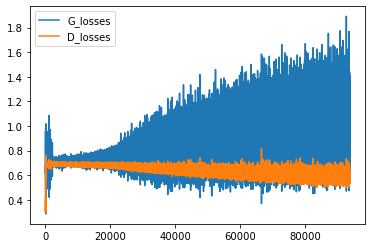

In [13]:
plt.plot(g_losses, label='G_losses')
plt.plot(d_losses, label='D_losses')
plt.legend()

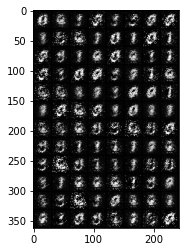

In [14]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

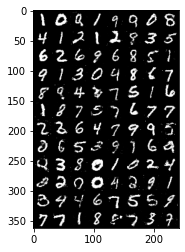

In [15]:
a = imread('gan_images/50.png')
plt.imshow(a)

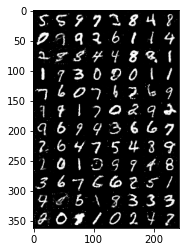

In [16]:
a = imread('gan_images/100.png')
plt.imshow(a)

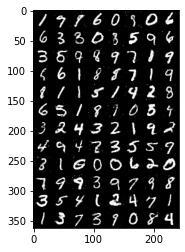

In [17]:
a = imread('gan_images/150.png')
plt.imshow(a)

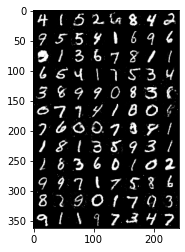

In [18]:
a = imread('gan_images/200.png')
plt.imshow(a)